# ML MODELING

In [2]:
import warnings
warnings.filterwarnings("ignore")
import sys
import os



In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
sns.set()


In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import mlflow

In [5]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn import metrics

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

In [7]:
from datetime import datetime
from pickle import dump
import mlflow
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV

In [8]:
sys.path.append(os.path.abspath(os.path.join('data')))
sys.path.insert(0,'../Scripts/')
from cleaner import DataCleaner
from data_information import DataInfo
from Data_logger import CreateLogger
from data_manipulation import DataManipulator
from Graphs import draw
from Results import result_picker



In [9]:
clean_df =pd.read_csv('../data2/train_store.csv')

In [10]:
clean_df.head()

,DayOfWeek,WeekDay,Year,Month,Season,Day,MonthTiming,Sales,Customers,Open,...,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,SalesPerCustomer,CompetitionOpenSince
0,0.501484,0.630672,1.502077,0.346724,0.389712,1.740766,1.205894,-0.063134,-0.067027,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.093996,0.595717
1,0.000831,0.630672,1.502077,0.346724,0.389712,1.626969,1.205894,-0.136239,-0.092863,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.207208,0.595717
2,-0.499823,0.630672,1.502077,0.346724,0.389712,1.513173,1.205894,-0.207840,-0.158887,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.227101,0.595717
3,-1.000476,0.630672,1.502077,0.346724,0.389712,1.399377,1.205894,-0.138946,-0.052674,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,-0.303632,0.595717
4,-1.501129,0.630672,1.502077,0.346724,0.389712,1.285581,1.205894,0.189274,0.096598,0.452399,...,-0.940975,-0.538742,0.436247,-0.385752,-1.001128,-0.421904,-0.305054,0.045131,0.097227,0.595717


# Random Forest Regression

In [11]:
#separation the data as dependent and independent var
X = clean_df.drop(['Customers', 'Sales', 'SalesPerCustomer'], axis = 1)
y = clean_df['Sales']

In [12]:
# Splitting Data (60,20,20) of train test and validation respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [13]:
# Define the Pipeline
model_pipeline = Pipeline(steps=[('random_forest', RandomForestRegressor(max_depth=10,random_state=2))])

In [14]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    print("RMSE Score is: {:.5%}".format(rmse))
    print("R2 Square Score is: {:.5%}".format(r2))
    print("MAE Score is: {:.5%}".format(mae))
    return {f'RMSE Score': rmse, f'R2_Squared': r2, f'MAE Score': mae}

In [15]:
# Fit the pipeline with the data
mlflow.autolog(log_input_examples=True, disable_for_unsupported_versions=True, silent=True)
with mlflow.start_run() as run:
    best_model = model_pipeline.fit(X_train, y_train)

    train_score = best_model.score(X_train, y_train)
    valid_score = best_model.score(X_valid, y_valid)
    valid_metrics = eval_metrics(y_valid, best_model.predict(X_valid))
    test_score = best_model.score(X_test, y_test)
    test_metrics = eval_metrics(y_test, best_model.predict(X_test))

    mlflow.log_metric("Valid Score", valid_score)
    mlflow.log_metrics(valid_metrics)
    mlflow.log_metric("Test Score", test_score)
    mlflow.log_metrics(test_metrics)

RMSE Score is: 52.93644%
R2 Square Score is: 71.90404%
MAE Score is: 37.50832%
RMSE Score is: 52.90944%
R2 Square Score is: 72.05642%
MAE Score is: 37.50892%


In [16]:
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [{
     'random_forest': [RandomForestRegressor(max_depth=10, random_state=2)],
     'random_forest__bootstrap': [True, True],
     'random_forest__ccp_alpha': [0.0],
     'random_forest__criterion': ['mse'],
     'random_forest__max_depth': [5,8,15],
     'random_forest__max_features': ['auto'],
     'random_forest__min_impurity_decrease': [0.0],
     'random_forest__min_samples_leaf': [1,5],
     'random_forest__min_samples_split': [2],
     'random_forest__min_weight_fraction_leaf': [0.0],
     'random_forest__n_estimators': [100],
     'random_forest__oob_score': [False, True],
     'random_forest__random_state': [2],
     'random_forest__verbose': [0],
     'random_forest__warm_start': [True, False]
}]

    
# create a gridsearch of the pipeline, the fit the best model
grid_search_pipeline = GridSearchCV(
    model_pipeline, grid_param, cv=3, verbose=0, n_jobs=-1)  # Fit grid search

In [17]:
def generate_model_name(mse_score: float) -> str:
    now = datetime.now()
    dt_string = now.strftime("%d-%m-%Y-%H-%M-%S-")
    dt_string = dt_string + "{:.2%}".format(mse_score)
    return dt_string

In [18]:
valid_metrics

{'RMSE Score': 0.5293644157874668,
 'R2_Squared': 0.7190404274836455,
 'MAE Score': 0.3750831964535372}

Text(0.5, 1.0, 'Valid Metrics')

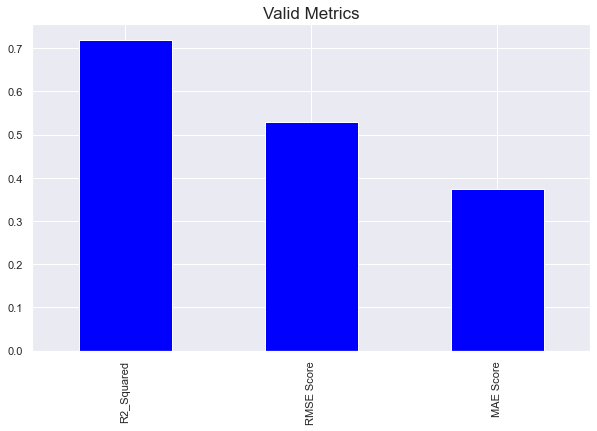

In [19]:
plt.figure(figsize=(10,6))
feat_importances = pd.Series(valid_metrics, index = valid_metrics.keys())
feat_importances.nlargest(10).plot(kind='bar',color='blue');
plt.title('Valid Metrics',size=17)

In [20]:
test_metrics

{'RMSE Score': 0.52909444368583,
 'R2_Squared': 0.7205641551568762,
 'MAE Score': 0.3750892205643945}

Text(0.5, 1.0, 'Test Metrics')

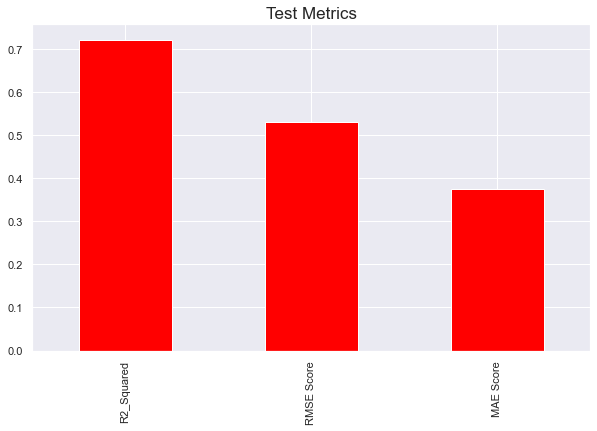

In [22]:
plt.figure(figsize=(10,6))
feat_importances = pd.Series(test_metrics, index = test_metrics.keys())
feat_importances.nlargest(10).plot(kind='bar',color='red');
plt.title('Test Metrics',size=17)

In [23]:
def save_model(model, mse_score) -> None:
    try:
        file_name = '../models/' + generate_model_name(mse_score=mse_score) +'.pkl'
        with open(file_name, 'wb') as handle:
            dump(model, handle)
    except Exception as e:
        print('Error while producing model')

In [25]:
#save_model(best_model, test_metrics['RMSE Score'])

In [26]:
best_model.get_params()

{'memory': None,
 'steps': [('random_forest',
   RandomForestRegressor(max_depth=10, random_state=2))],
 'verbose': False,
 'random_forest': RandomForestRegressor(max_depth=10, random_state=2),
 'random_forest__bootstrap': True,
 'random_forest__ccp_alpha': 0.0,
 'random_forest__criterion': 'mse',
 'random_forest__max_depth': 10,
 'random_forest__max_features': 'auto',
 'random_forest__max_leaf_nodes': None,
 'random_forest__max_samples': None,
 'random_forest__min_impurity_decrease': 0.0,
 'random_forest__min_impurity_split': None,
 'random_forest__min_samples_leaf': 1,
 'random_forest__min_samples_split': 2,
 'random_forest__min_weight_fraction_leaf': 0.0,
 'random_forest__n_estimators': 100,
 'random_forest__n_jobs': None,
 'random_forest__oob_score': False,
 'random_forest__random_state': 2,
 'random_forest__verbose': 0,
 'random_forest__warm_start': False}